### **Fitting on MIMIC-IV data**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../nn_survival_analysis')
from nn_survival_analysis.general_utils import *
from nn_survival_analysis.model_utils import *
from nn_survival_analysis.losses import *
from nn_survival_analysis.models import *
from nn_survival_analysis.other_nn_models import *
from nn_survival_analysis.time_invariant_surv import *
from nn_survival_analysis.time_variant_surv import *
from nn_survival_analysis.traditional_models import *
import scipy

# define sigmoid function - will be handy later
sigmoid = lambda z : 1 / (1 + np.exp(-z))

config_file_path = '../nn_survival_analysis/config.json'

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Load Data for TIS

In [2]:
data_folder_path = '../data/'

# Get configs
with open(config_file_path, "r") as file:
        configs = json.load(file)

# Read the pickled DataFrames
with open(data_folder_path+'x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open(data_folder_path+'x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open(data_folder_path+'x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)

### **Testing Time-Invariant Performance**

In [5]:
%%time
print(configs['time_invariant']['training'])
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)
print(tis_cindex , tis_ibs)

{'clusters': 1, 'q_cuts': 15, 'hidden_size': 25, 'alpha': 0.01, 'batch_size': 256, 'num_epochs': 400, 'learning_rate': 0.001, 'shuffle': True, 'patience': 20, 'dropout': 0.5}
training cluster 0
Epoch 50: Training Loss: 0.0095505, Val Loss: 0.0052621
Epoch 100: Training Loss: 0.0043069, Val Loss: 0.0003483
Epoch 150: Training Loss: -0.0014207, Val Loss: -0.0023851
Epoch 200: Training Loss: 0.0014088, Val Loss: -0.0044962
Epoch 250: Training Loss: -0.0057440, Val Loss: -0.0054940
Epoch 300: Training Loss: -0.0150461, Val Loss: -0.0089028
Epoch 350: Training Loss: -0.0084193, Val Loss: -0.0078845
Epoch 400: Training Loss: -0.0150698, Val Loss: -0.0081643
shapes : (1325, 1325, 1325, 1325)
0.6755224806775925 0.34434897163726946
CPU times: total: 4min 43s
Wall time: 1min 4s


### Load Data for TVS

In [4]:
data_folder_path = '../data/'

# Get configs
with open(config_file_path, "r") as file:
        configs = json.load(file)
        
# Read the pickled DataFrames
with open(data_folder_path+'x_train_reshape_tv.pickle', 'rb') as file:
    x_train_reshape_tv = pickle.load(file)
with open(data_folder_path+'x_test_reshape_tv.pickle', 'rb') as file:
    x_test_reshape_tv = pickle.load(file)
with open(data_folder_path+'x_val_reshape_tv.pickle', 'rb') as file:
    x_val_reshape_tv = pickle.load(file)

# Read the pickled targets
with open(data_folder_path+'y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open(data_folder_path+'y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)
with open(data_folder_path+'y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

### **Testing Time-Variant Performance**

In [5]:
%%time
print(configs['time_variant']['training'])
#-----------------------------------------------------------------------------------------------
# instantiate - Time Variant Survival
tvs = Time_Variant_Survival(
            configs = configs, 
            x_train_reshape_tv = x_train_reshape_tv,
            x_test_reshape_tv = x_test_reshape_tv, 
            x_val_reshape_tv = x_val_reshape_tv,
            y_train = y_train,
            y_test = y_test,
            y_val = y_val
)

# fit
tvs.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tvs.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tvs_cindex , tvs_ibs = tvs.evaluation(mean_ , y_test_dur , y_test_event, plot = False)
print(tvs_cindex , tvs_ibs)

# {'q_cuts': 10, 'hidden_size': 30, 'alpha': 0.001, 'batch_size': 64, 'num_epochs': 100, 'learning_rate': 0.001, 'shuffle': True, 'patience': 50, 'dropout': 0.5}
# shapes : (1180, 1180, 1180, 1180)
# 0.7208971317662282 0.35702184920448965
# CPU times: total: 16min 11s
# Wall time: 2min 22s

{'q_cuts': 15, 'hidden_size': 25, 'alpha': 0.01, 'batch_size': 256, 'num_epochs': 100, 'learning_rate': 0.001, 'shuffle': True, 'patience': 20, 'dropout': 0.5}


Epoch 50: Training Loss: -0.0157622, Val Loss: -0.0074888
Epoch 100: Training Loss: -0.0188709, Val Loss: -0.0159662
shapes : (1180, 1180, 1180, 1180)
0.732845308590168 0.36489027698829357
CPU times: total: 11min 54s
Wall time: 2min 3s


#### Other Fitters

In [9]:
%%time
#-----------------------------------------------------------------------------------------------
# instantiate - PyCox
pyc = PYC(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val, num_durations = 10)

# fit
pyc.fit()

# eval
pyc_cindex , pyc_ibs = pyc.eval()
        
print(f'PyCox: cindex {pyc_cindex} , ibs {pyc_ibs}')
#-----------------------------------------------------------------------------------------------
# instantiate - Deep Survival Machines
dsm = DSM(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val, num_durations = 10)

# fit
dsm.fit()

# eval
dsm_cindex , dsm_ibs = dsm.eval()
       
print(f'Deep Survival Machines: cindex {dsm_cindex} , ibs {dsm_ibs}')

# -----------------------------------------------------------------------------------------------
# instantiate - CPH
cph = CPH(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val)

# fit
cph.fit()
# eval
cph_cindex , cph_ibs = cph.eval(fitter_is_rsf = False)
        
print(f'Cox Proportional Hazards: cindex {cph_cindex} , ibs {cph_ibs}')

#-----------------------------------------------------------------------------------------------
# instantiate - AFT
aft = AFT(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val)

# fit
aft.fit()
# eval
aft_cindex , aft_ibs = aft.eval(fitter_is_rsf = False)
        
print(f'Weibull Accelerated Failure Time: cindex {aft_cindex} , ibs {aft_ibs}')

# -----------------------------------------------------------------------------------------------
# instantiate - RSF
rsf = RSF(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val)

# fit
rsf.fit()
# eval
rsf_cindex , rsf_ibs = rsf.eval(fitter_is_rsf = True)

print(f'Random Survival Forest: cindex {rsf_cindex} , ibs {rsf_ibs}')

shapes : (1325, 1325, 1325, 1325)
Cox Proportional Hazards: cindex 0.6863477202856957 , ibs 0.15890010506008065
CPU times: total: 14.2 s
Wall time: 14.7 s


### **Explanation for TIS**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Expected value -5.997389793395996
Subject value -7.136213779449463


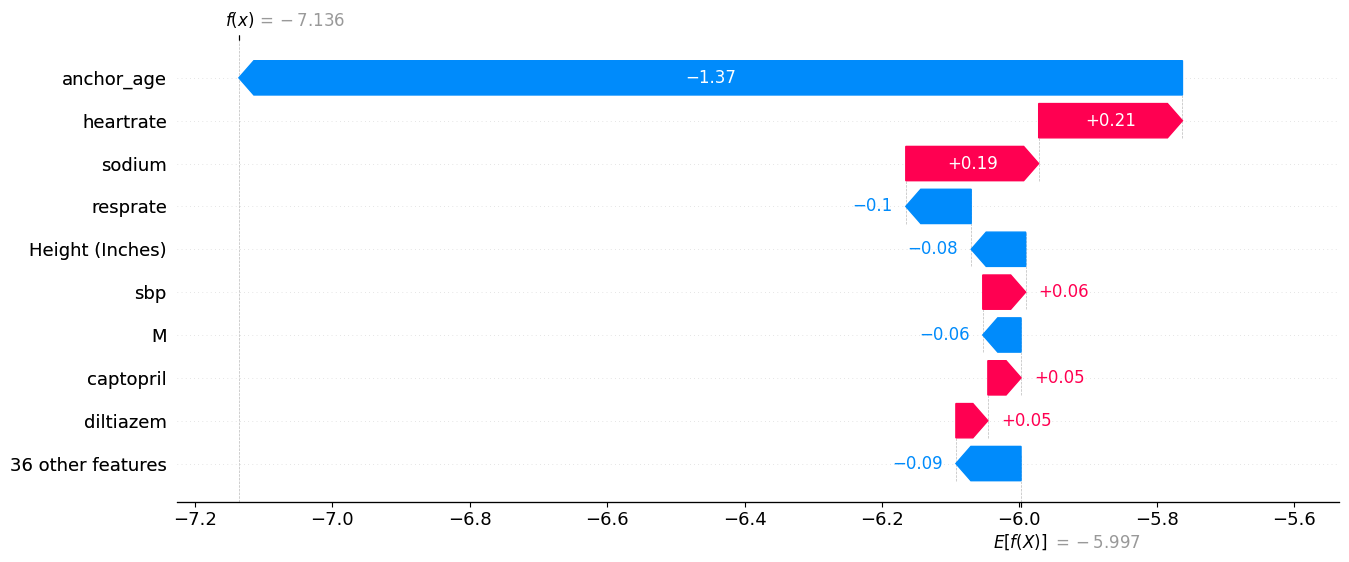

In [6]:
# what caused the model predictions to deviate for the 50th patient at the 10th time stamp?
t_s , pat_num = 0 , 50
tis.explain_with_shap(background_size = 500 , explained_size = 100)
tis.plot_explain(plot_type = 'waterfall' , t_s = t_s , pat_num = pat_num)

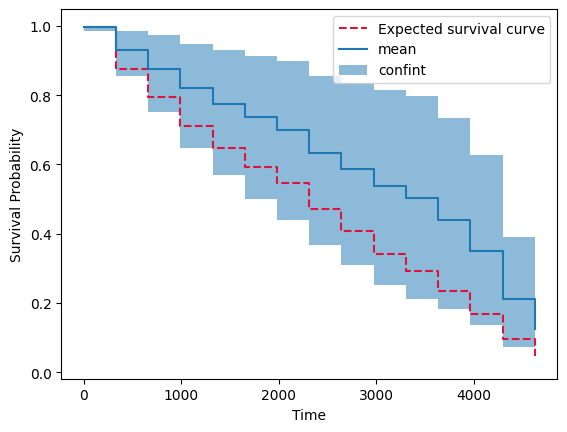

In [7]:
# get death time and event indicator
y_test_dur_ , y_test_event_ = get_target(x_test)

t_test = Transforms(durations = y_test_dur_)
dur_idx_test = t_test.discrete_transform(_cuts = configs['time_invariant']['training']['q_cuts'])

# Expected survival curve
plt.step(
    t_test.bin_edges , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) , 
    where = 'post' , color = 'crimson' , ls = '--' ,
    label = 'Expected survival curve'
    )

mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict()

# Visualize
tis.visualize(mean_ , up_ , low_ , _from = pat_num , _to = None)
plt.legend()
plt.savefig('diff_exp_curve.pdf' , format = 'pdf')
plt.show()

### **Trying to compare survival curves**

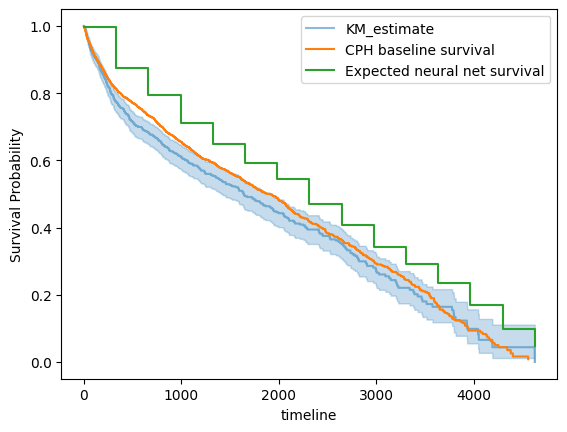

In [10]:
fig , ax = plt.subplots()

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = x_test["time_to_event"]
E = x_test["death"]

kmf.fit(T, event_observed=E)
kmf.plot_survival_function(alpha = 0.5);

# CPH
ax.step((cph.fitter.baseline_survival_).index , (cph.fitter.baseline_survival_)['baseline survival'] , where = 'post' , label = 'CPH baseline survival')

# Expected survival curve
ax.step(t_test.bin_edges , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) , where = 'post' , label = 'Expected neural net survival')
ax.legend()
ax.set_ylabel('Survival Probability');

plt.savefig('comparing_surv_curve.pdf' , format = 'pdf')
plt.show()

#### **Testing Statistical similarity**

In [11]:
print(f"KM-NN {scipy.stats.kstest((kmf.survival_function_)['KM_estimate'] , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) )}")
print(f"CPH-NN {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) )}")
print(f"KM-CPH {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , (kmf.survival_function_)['KM_estimate'] )}")

KM-NN KstestResult(statistic=0.28776716689404275, pvalue=0.14283091718970994, statistic_location=0.4700881838798523, statistic_sign=-1)
CPH-NN KstestResult(statistic=0.25538398188182004, pvalue=0.24168608460745114, statistic_location=0.4700881838798523, statistic_sign=-1)
KM-CPH KstestResult(statistic=0.08672424239104697, pvalue=0.0009344653078923103, statistic_location=0.826160838886392, statistic_sign=1)
